Imports

In [1]:
import os
import warnings
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
print(os.listdir("./input"))
warnings.filterwarnings("ignore")

/home/david/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['DATASET.md', 'wm811k-wafer-map']


Read Pickle

In [2]:
df = pd.read_pickle("./input/wm811k-wafer-map/LSWMD.pkl")
df.info()
df = df.drop(['waferIndex'], axis = 1)

def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

print(max(df.waferMapDim), min(df.waferMapDim))

print(df.info())
display(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB
(300, 202) (6, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   trianTestLabel  811457 non-null  object 
 4   failureType     811457 non-null  object 
 5   waferMapDim  

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"


In [3]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
display(df.sample(10))

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
147660,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",14116.0,lot9456,[],[],"(212, 84)",[],[]
223288,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1507.0,lot14061,[],[],"(44, 44)",[],[]
115715,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",710.0,lot7716,[],[],"(32, 29)",[],[]
103570,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1507.0,lot7097,[],[],"(44, 44)",[],[]
107388,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",845.0,lot7304,[],[],"(35, 31)",[],[]
714617,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1296.0,lot43612,[[Test]],[[none]],"(41, 41)",8,1
230546,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7810.0,lot14449,[],[],"(89, 112)",[],[]
743083,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",895.0,lot44767,[[Test]],[[none]],"(33, 35)",8,1
318518,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot19334,[],[],"(45, 43)",[],[]
779739,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1414.0,lot46255,[[Test]],[[none]],"(42, 44)",8,1


In [4]:
tol_wafers = df.shape[0]
print(tol_wafers)

811457


In [5]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
print(df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0])

172950 25519 147431


In [7]:
df_withpattern = pd.concat([df_withpattern, df_nonpattern.iloc[:25519//8,:]], ignore_index=True)
print(df_withpattern.info())
df_withpattern["encoded_labels"] = df_withpattern["failureType"].replace(mapping_type)
print(df_withpattern.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31897 entries, 0 to 31896
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           25519 non-null  float64
 1   waferMap        31897 non-null  object 
 2   dieSize         31897 non-null  float64
 3   lotName         31897 non-null  object 
 4   trianTestLabel  31897 non-null  object 
 5   failureType     31897 non-null  object 
 6   waferMapDim     31897 non-null  object 
 7   failureNum      31897 non-null  object 
 8   trainTestNum    31897 non-null  object 
 9   encoded_labels  28708 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.4+ MB
None
          index                                           waferMap  dieSize  \
27109       NaN  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1,...    533.0   
8905   268797.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1658.0   
31100       NaN  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,

In [8]:
# resize all to 300 x 300

def resize_wafer_map(wafer_map, size=(300, 300)):
    """
    Resize a 2D wafer map to the specified size.
    :param wafer_map: 2D numpy array representing the wafer map.
    :param size: Tuple indicating the target size (width, height).
    :return: Resized wafer map as a 2D numpy array.
    """
    # Ensure the wafer map is a numpy array
    wafer_map = np.array(wafer_map)

    # Use OpenCV to resize
    resized_map = cv2.resize(wafer_map, size, interpolation=cv2.INTER_AREA)

    return resized_map

for idx, item in df_withpattern.iterrows():
    wafer_map = item['waferMap']  # Extract the wafer map
    resized_map = resize_wafer_map(wafer_map)
    df_withpattern.at[idx, 'waferMap'] = resized_map  # Update the wafer map in the data

print(df_withpattern.sample(5))


          index                                           waferMap  dieSize  \
4144   154713.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1291.0   
12122  361140.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1080.0   
703     14282.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   3927.0   
26212       NaN  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    533.0   
31366       NaN  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    533.0   

        lotName trianTestLabel    failureType waferMapDim failureNum  \
4144   lot10049   [[Training]]  [[Edge-Ring]]    (41, 41)          3   
12122  lot21623   [[Training]]  [[Edge-Ring]]    (35, 40)          3   
703     lot2160   [[Training]]  [[Edge-Ring]]    (69, 73)          3   
26212     lot34   [[Training]]       [[none]]    (26, 26)          8   
31366    lot127   [[Training]]       [[none]]    (26, 26)          8   

      trainTestNum  encoded_labels  
4144             0               3  
12122            0

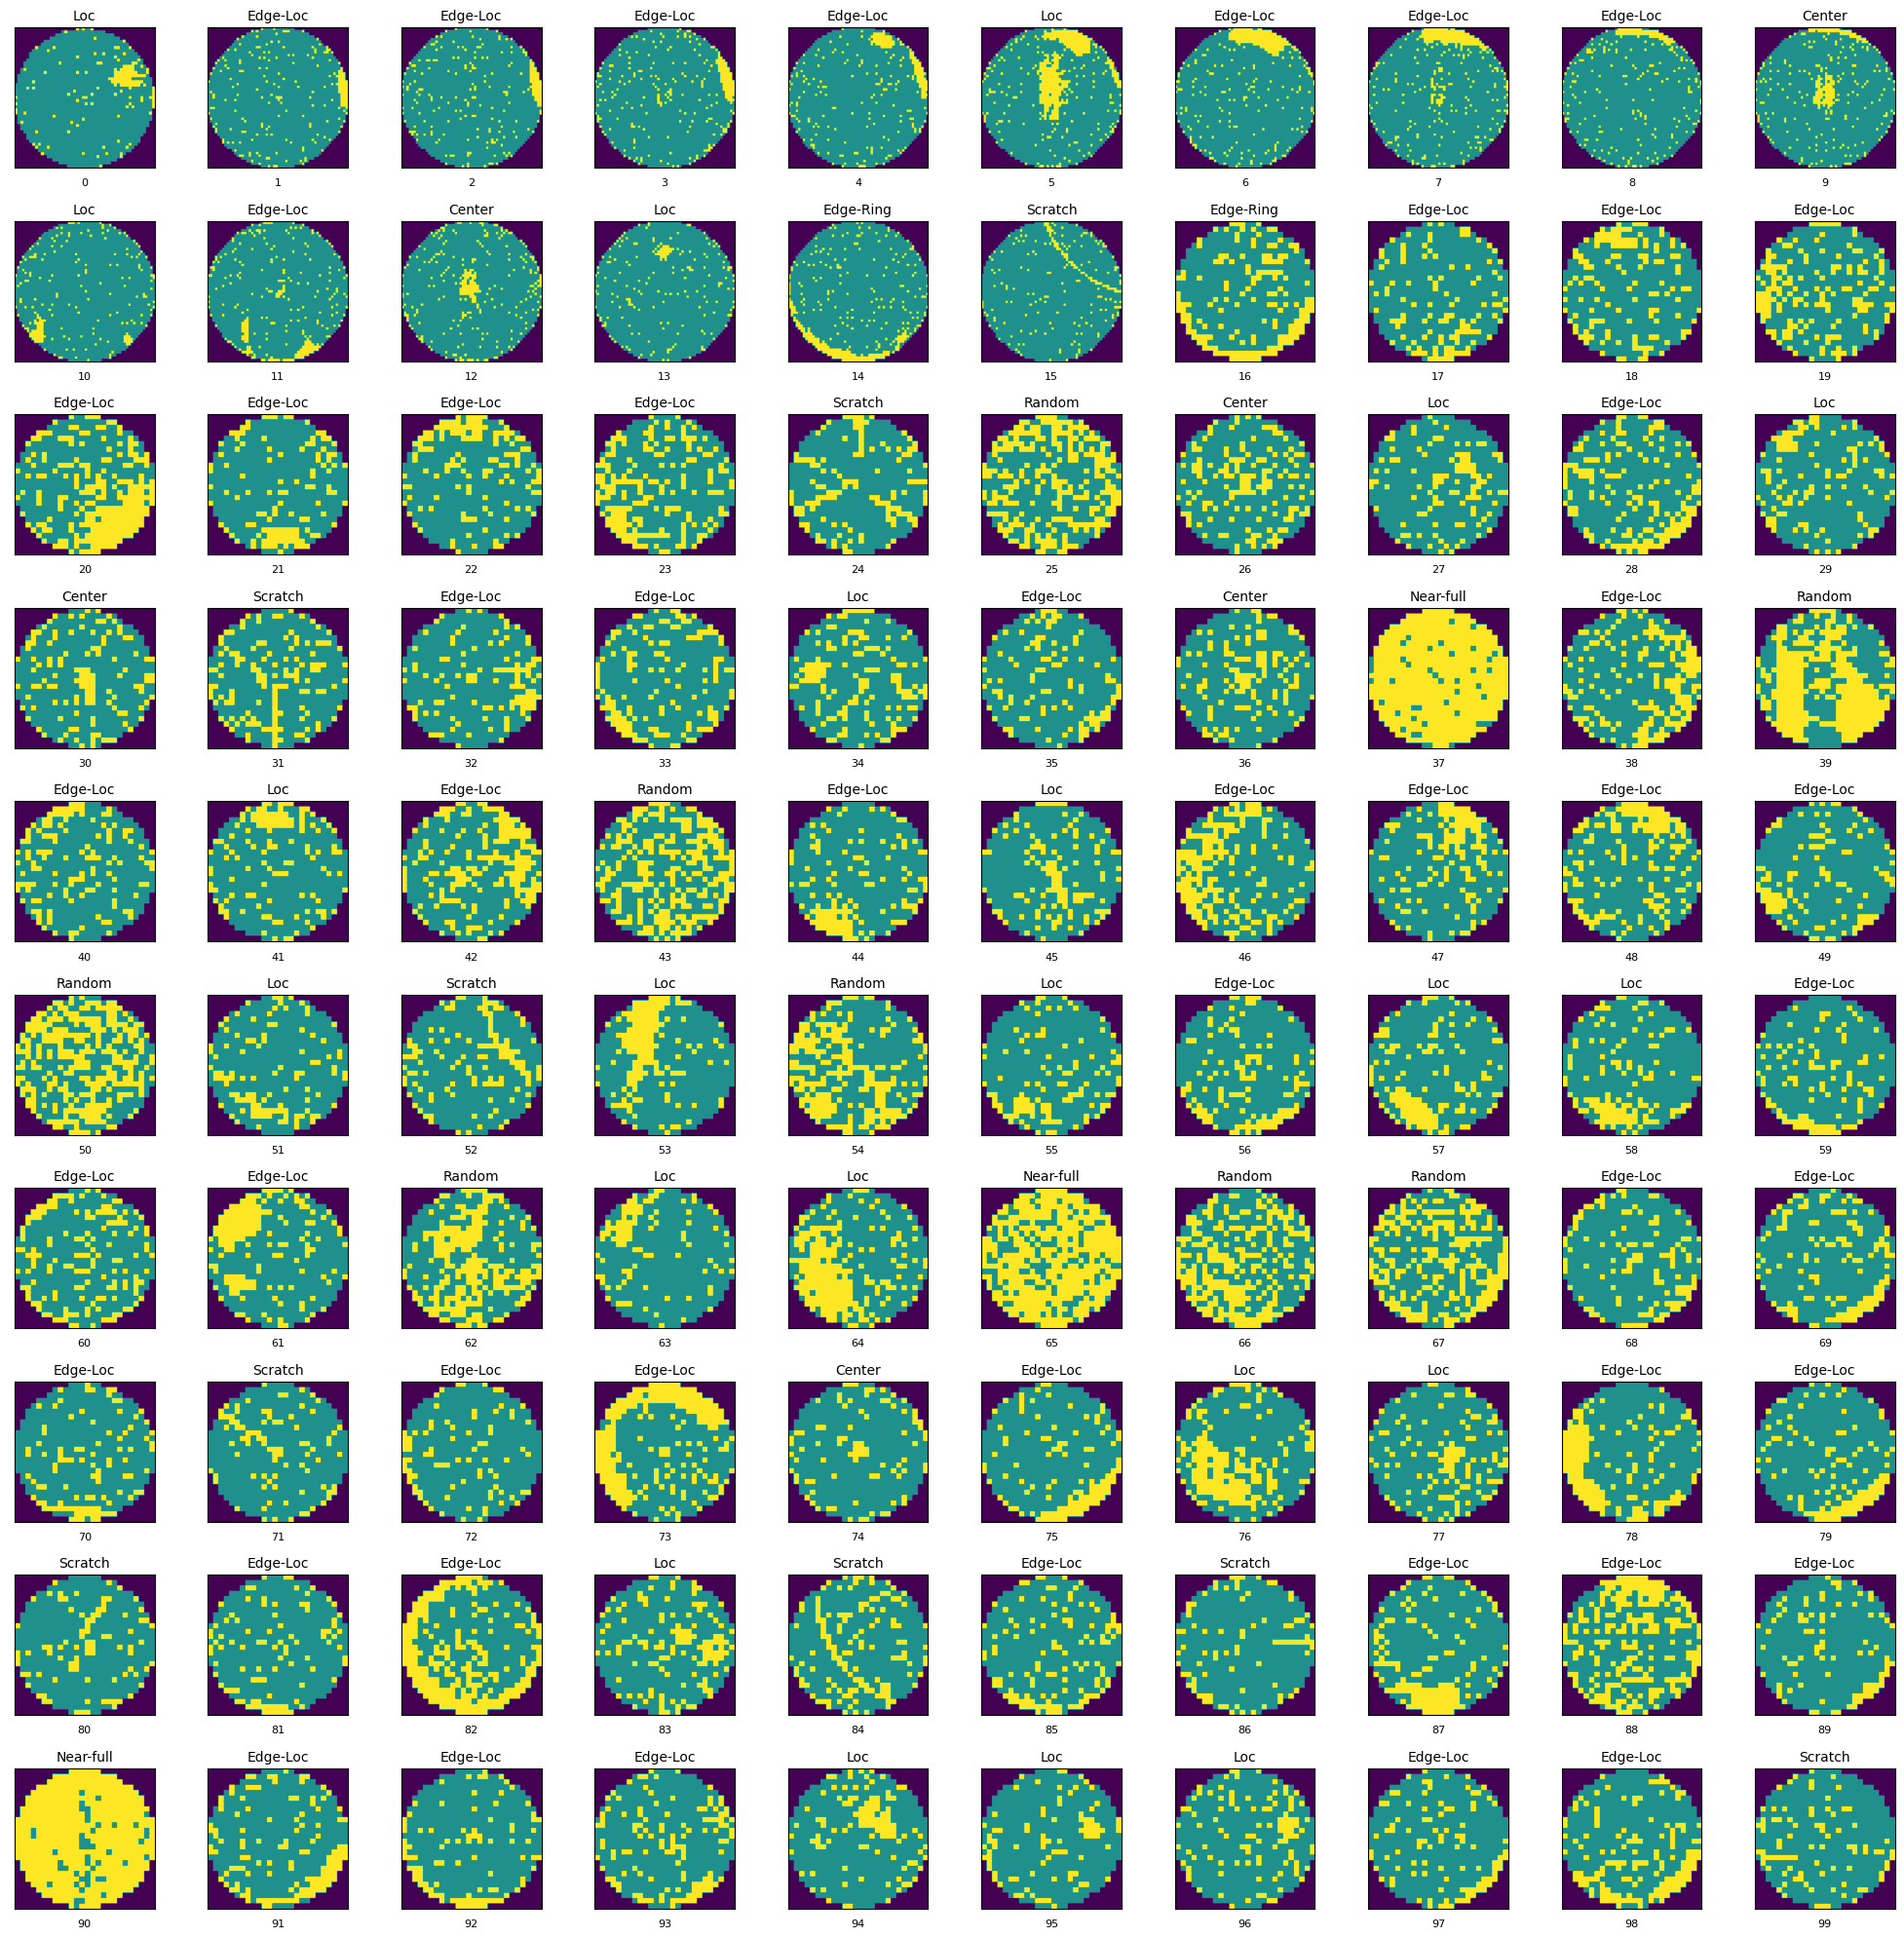

In [9]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [24]:
train_data_length = int(0.8*len(df_withpattern)) 
df_with_label = df_withpattern.sample(frac=1, random_state=2)
df_train, df_test = df_with_label[:train_data_length], df_with_label[train_data_length:]
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

train_data_length = int(0.75*len(df_train))
df_train, df_val = df_train[:train_data_length], df_train[train_data_length:]
print(f"training: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}, (all: {len(df_with_label)})")

# This aims to save the data into your environment.
df_train.to_pickle("dataset_train.pickle")
df_val.to_pickle("dataset_val.pickle")
df_test.to_pickle("dataset_test.pickle")
print(os.listdir())

training: 17224, val: 5742, test: 5742, (all: 28708)
['dataset_test.pickle', 'README.md', 'LICENSE', 'datasets', 'input', 'runs', 'LSWMD_25519.pkl', '.gitignore', 'dataset_val.pickle', 'config_class2idx.json', 'yolo_dataset.yaml', 'main.ipynb', 'yolo11n.pt', 'dataset_train.pickle', '.git']


In [25]:
train_dir = 'yolo_dataset/train'
val_dir = 'yolo_dataset/val'
test_dir = 'yolo_dataset/test'
class_names = list(mapping_type.keys())
datasets_dir = 'datasets/'

output_yaml_path = 'yolo_dataset.yaml'

In [26]:
def process_wafer_map_to_image(wafer_map, output_image_path):
    """
    Convert a 2D wafer map into an image and save it.
    :param wafer_map: 2D numpy array representing the wafer map.
    :param output_image_path: Path to save the image.
    """
    # Normalize the wafer map to a range suitable for an image (0-255)
    wafer_map_normalized = (np.array(wafer_map) **7 / np.max(wafer_map)).astype(np.uint8)
    
    # Save as a grayscale image
    cv2.imwrite(output_image_path, wafer_map_normalized)

def process_split(data, output_dir):
    """
    Process the split pickle file into YOLO format.
    :param split_file: Path to the pickle file.
    :param output_dir: Directory to save YOLO-formatted images and labels.
    """
    # Load the pickle file
    images_dir = os.path.join(output_dir, "images")
    labels_dir = os.path.join(output_dir, "labels")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    for idx, row in data.iterrows():
        wafer_map = row['waferMap']  # Extract wafer map
        encoded_labels = row['encoded_labels']

        # Generate paths
        image_path = os.path.join(images_dir, f"{encoded_labels}_{idx}.png")
        label_path = os.path.join(labels_dir, f"{encoded_labels}_{idx}.txt")

        # Save the image
        process_wafer_map_to_image(wafer_map, image_path)

        # Write the label (assume whole image belongs to a single class)
        class_id = encoded_labels  # Change this if there are multiple classes
        with open(label_path, 'w') as label_file:
            # YOLO format requires <class_id> <x_center> <y_center> <width> <height>
            # Since the whole image belongs to one class, we use a bounding box that spans the image.
            label_file.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

# Define output directories for each split
os.makedirs(datasets_dir + train_dir, exist_ok=True)
os.makedirs(datasets_dir + val_dir, exist_ok=True)
os.makedirs(datasets_dir + test_dir, exist_ok=True)

# Process each split
process_split(df_train, datasets_dir + train_dir)
process_split(df_val, datasets_dir + val_dir)
process_split(df_test, datasets_dir + test_dir)

data = {
        'train': train_dir,
        'val': val_dir,
        'test': test_dir,
        'nc': len(class_names),
        'names': class_names
    }
    
with open(output_yaml_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)
    
print(f"YAML file created at {output_yaml_path}")

YAML file created at yolo_dataset.yaml


In [27]:
from ultralytics import YOLO
output_yaml_path = 'yolo_dataset.yaml'

model = YOLO("yolo11n.pt")
results = model.train(data=output_yaml_path, epochs=100, imgsz=300)

Ultralytics 8.3.34 🚀 Python-3.8.10 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8192MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=yolo_dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=300, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning /home/david/Wafer-Defect-CNN/datasets/yolo_dataset/train/labels... 29327 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29327/29327 [00:24<00:00, 1208.14it/s]


train: New cache created: /home/david/Wafer-Defect-CNN/datasets/yolo_dataset/train/labels.cache


val: Scanning /home/david/Wafer-Defect-CNN/datasets/yolo_dataset/val/labels... 10179 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10179/10179 [00:09<00:00, 1090.10it/s]


val: New cache created: /home/david/Wafer-Defect-CNN/datasets/yolo_dataset/val/labels.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.803G     0.4829      1.859       1.06         44        320: 100%|██████████| 1833/1833 [03:15<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 16/319 [00:02<00:39,  7.65it/s]


RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/home/david/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 38, in do_one_step
    data = pin_memory(data, device)
  File "/home/david/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 69, in pin_memory
    clone.update({k: pin_memory(sample, device) for k, sample in data.items()})
  File "/home/david/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 69, in <dictcomp>
    clone.update({k: pin_memory(sample, device) for k, sample in data.items()})
  File "/home/david/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in pin_memory
    return data.pin_memory(device)
RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

